In [ ]:
import cv2
import os
import sklearn
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.compat.v1.Session(config=config)
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

IMAGE_SIZE = 128
BATCH_SIZE = 16
VERBOSE = 1

class_names = ["no", "yes"]
base_path = "../input/brain-tumor-detection"

x_train=[]
y_train=[]

for i in class_names:
    folderPath = os.path.join(base_path,i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

print('Testing dataset Loading complete.')

x_train, x_test, y_train, y_test = train_test_split(x_train,
                                                    y_train,
                                                    random_state=47,
                                                    test_size=0.10)

y_train_new = [class_names.index(i) for i in y_train]
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
y_test_new = [class_names.index(i) for i in y_test]
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

2022-08-07 09:38:23.801910: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-07 09:38:23.875840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 09:38:23.991636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 09:38:23.992863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


100%|████████████████████████████| 1500/1500 [00:14<00:00, 106.89it/s]


Training dataset Loading complete.
Testing dataset Loading complete.


In [ ]:
inputShape = (IMAGE_SIZE, IMAGE_SIZE, 3)
xception = Xception(weights="../input/pretrained-model/xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
                    input_shape=inputShape, include_top=False)
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(2, activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs=model)

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("xception.h5",monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3, patience = 2,
                              min_delta = 0.001,mode='auto',
                              verbose=VERBOSE)

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history=model.fit(aug.flow(x_train, y_train,batch_size=BATCH_SIZE),
          
validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE,
epochs=3, callbacks=[reduce_lr, checkpoint, tensorboard])
result = model.evaluate(x_test, y_test)
print(result)

2022-08-07 09:38:53.880109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 09:38:53.881097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 09:38:53.881766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 09:38:53.882475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 09:38:53.883133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/3


2022-08-07 09:39:01.934730: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-08-07 09:39:07.590636: W tensorflow/core/common_runtime/bfc_allocator.cc:338] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


  1/168 [..............................] - ETA: 31:07 - loss: 0.7890 - accuracy: 0.4375

2022-08-07 09:39:08.450614: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-07 09:39:08.450665: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/168 [..............................] - ETA: 1:23 - loss: 0.7415 - accuracy: 0.3750 

2022-08-07 09:39:08.858934: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-07 09:39:08.860601: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-07 09:39:09.006039: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1147 callback api events and 1144 activity events. 
2022-08-07 09:39:09.033564: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


  3/168 [..............................] - ETA: 1:15 - loss: 0.7097 - accuracy: 0.4792

2022-08-07 09:39:09.078578: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_08_07_09_39_09

2022-08-07 09:39:09.103089: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_08_07_09_39_09/0fbd10d77606.trace.json.gz
2022-08-07 09:39:09.166650: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_08_07_09_39_09

2022-08-07 09:39:09.174887: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_08_07_09_39_09/0fbd10d77606.memory_profile.json.gz
2022-08-07 09:39:09.178503: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/train/plugins/profile/2022_08_07_09_39_09
Dumped tool data for xplane.pb to logs/train/plugins/profile/2022_08_07_09_39_09/0fbd10d77606.xplane.

168/168 [==============================] - 28s 103ms/step - loss: 0.3362 - accuracy: 0.8655 - val_loss: 0.4487 - val_accuracy: 0.9333

Epoch 00001: val_accuracy improved from -inf to 0.93333, saving model to xception.h5
Epoch 2/3
168/168 [==============================] - 16s 93ms/step - loss: 0.1749 - accuracy: 0.9449 - val_loss: 0.2710 - val_accuracy: 0.9333

Epoch 00002: val_accuracy did not improve from 0.93333
Epoch 3/3
168/168 [==============================] - 15s 88ms/step - loss: 0.1115 - accuracy: 0.9639 - val_loss: 0.0522 - val_accuracy: 0.9733

Epoch 00003: val_accuracy improved from 0.93333 to 0.97333, saving model to xception.h5
10/10 [==============================] - 0s 28ms/step - loss: 0.0522 - accuracy: 0.9733
[0.05222872272133827, 0.9733333587646484]


In [ ]:
from PIL import Image

In [ ]:
img = cv2.imread('../input/brain-tumor-detection/yes/y1005.jpg')
img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
img1=np.array(img)
img1=img1.reshape(1,128,128,3)
img1.shape

(1, 128, 128, 3)

Tumor Detected


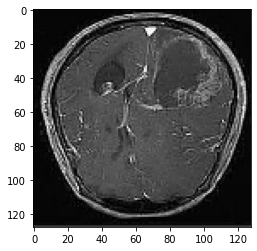

In [ ]:
plt.imshow(img)
predictions=model.predict(img1)
predict=np.argmax(predictions[0])
if predict==1:
    print("Tumor Detected")
else:
    print("No tumor detected")

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

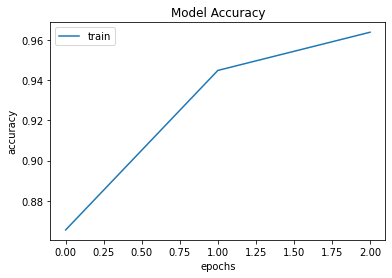

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train'],loc='upper left')
plt.show()

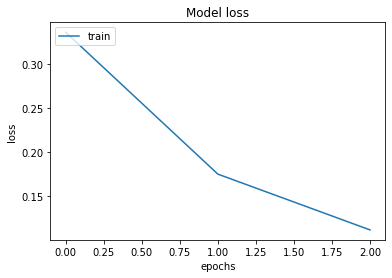

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train'],loc='upper left')
plt.show()

In [ ]:
'''loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,3)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()'''

In [ ]:
model.save("tumor.h5")